# Neural Networks

Lecture 3.

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

---

## Demo of world's simplest NN



In [33]:
from sklearn.neural_network import MLPRegressor

np.random.seed(12345)
X = np.random.normal(scale=2, size=(4*400,1))
y = X[:, 0]

clf = MLPRegressor(hidden_layer_sizes=(1,),
                   validation_fraction=0.2, tol=1e-9, max_iter=3200,
                   solver='sgd',
                   learning_rate_init=0.001,
                   #learning_rate_init=0.01,
                   #learning_rate_init=0.5,
                   momentum=0,
                   activation='tanh',
                   verbose=False, random_state=2)

# hidden_layer_sizes=(40, 40, 20) is a tuple which length is the number of INNER layers and each entry specify the number of neurons in that INNER layer.
clf.fit(X, y)
# The total number of layers is len(hidden_layer_sizes) + 2, since the first layer is the input layer and the last is the output layer.
print(clf.n_layers_, clf.n_outputs_)

3 1


0.065114704477


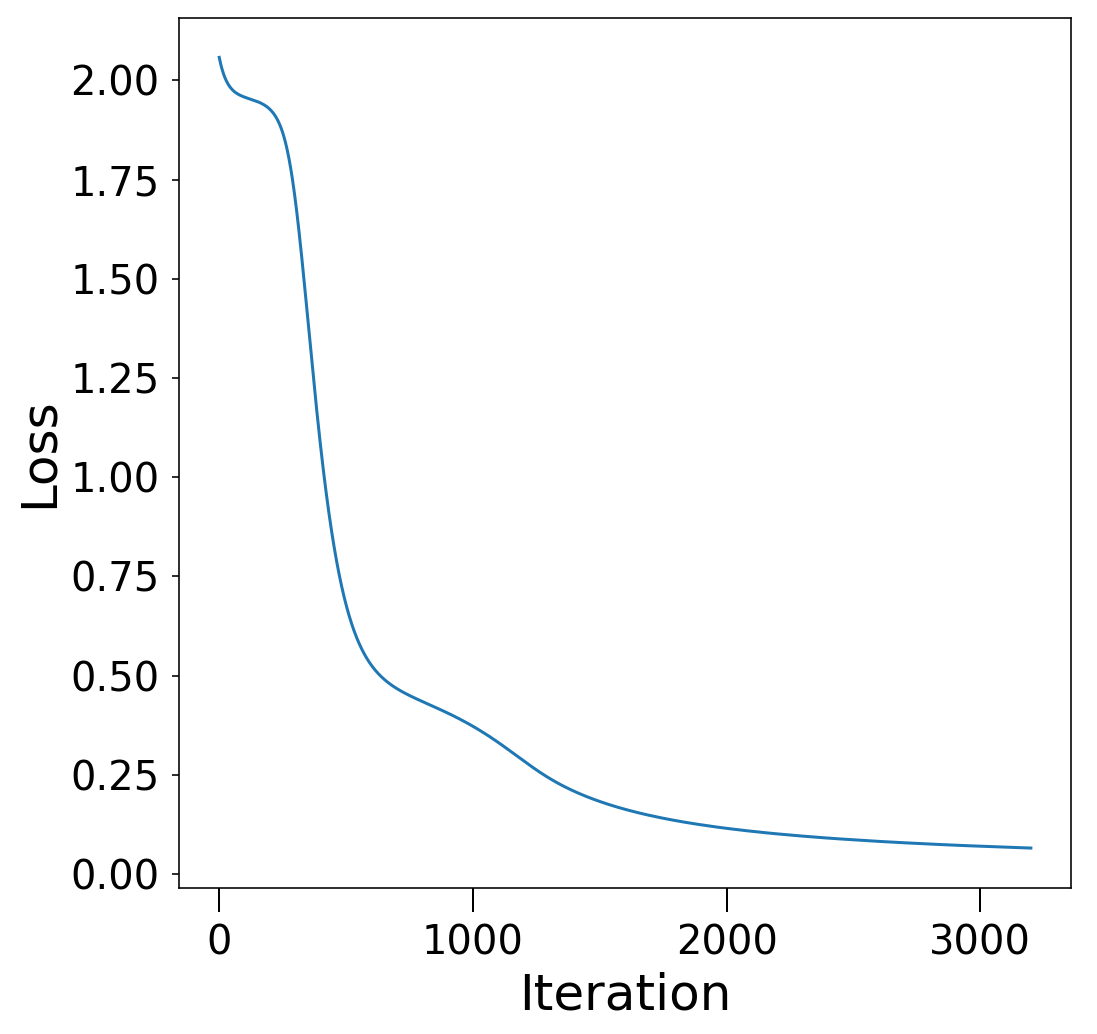

In [14]:
print(clf.loss_)
plt.plot(clf.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss');

In [15]:
clf.predict([[0.], [1.5], [-1.4]])

array([ 0.01023809,  1.69176755, -1.57832278])

---

## Ingredients for backpropagation

Implement two simple modules that know how to compute their "local" gradients. Then build up
a more complicated module that contains those two. We can treat each successive module
as a black-box that just "magically" knows how to analytically compute the gradients.

Below we implement $f(x, y, z) = (x+y)z$ and compute the gradient.

In [5]:
class Multiply:
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dLdz):
        dzdx = self.y
        dLdx = dLdz * dzdx
        
        dzdy = self.x
        dLdy = dLdz * dzdy
        return [dLdx, dLdy]


class Add:
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y
        
    def backward(self, dLdz):
        dzdy = 1
        dzdx = 1
        return [dLdz * dzdy, dLdz * dzdx]

In [6]:
def f_with_gradients(x, y, z):
    # create our operators
    q = Add()
    f = Multiply()
    
    # feed inputs into the summer first, then do multiplication
    # this builds our computational graph
    q_out = q.forward(x, y)
    f_out = f.forward(q_out, z)
    
    # this one is somehow weird ... but hey.
    # step backwards through our graph to compute the gradients
    grad_f = f.backward(1.)
    grad_q = q.backward(grad_f[0])

    # sort our gradients so we have [df/dx, df/dy, df/dz]
    gradients = [grad_q[0], grad_q[1], grad_f[1]]
    return f_out, gradients

In [7]:
f_with_gradients(-2, 5, -4)

(-12, [-4.0, -4.0, 3.0])

We can now zoom out, make a "`f` module", that contains some differentiable magic on the inside and stop caring how it works:

In [8]:
class F:
    def forward(self, x, y, z):
        self.q = Add()
        self.f = Multiply()
        
        self.q_out = self.q.forward(x, y)
        self.f_out = self.f.forward(self.q_out, z)
        return self.f_out
    
    def backward(self, dfdz):
        grad_f = self.f.backward(dfdz)
        grad_q = self.q.backward(grad_f[0])
        
        return [grad_q[0], grad_q[1], grad_f[1]]

In [9]:
f = F()
print('f(x, y, z) = ', f.forward(-2, 5, -4))

print('[df/dx, df/dy, df/dz] = ', f.backward(1))

f(x, y, z) =  -12
[df/dx, df/dy, df/dz] =  [-4, -4, 3]


---

## Neural networks in scikit-learn

scikit-learn contains a simple neural network implementation. It is not meant to serve the needs of deep learning, but works well for small problems and is easy to use.

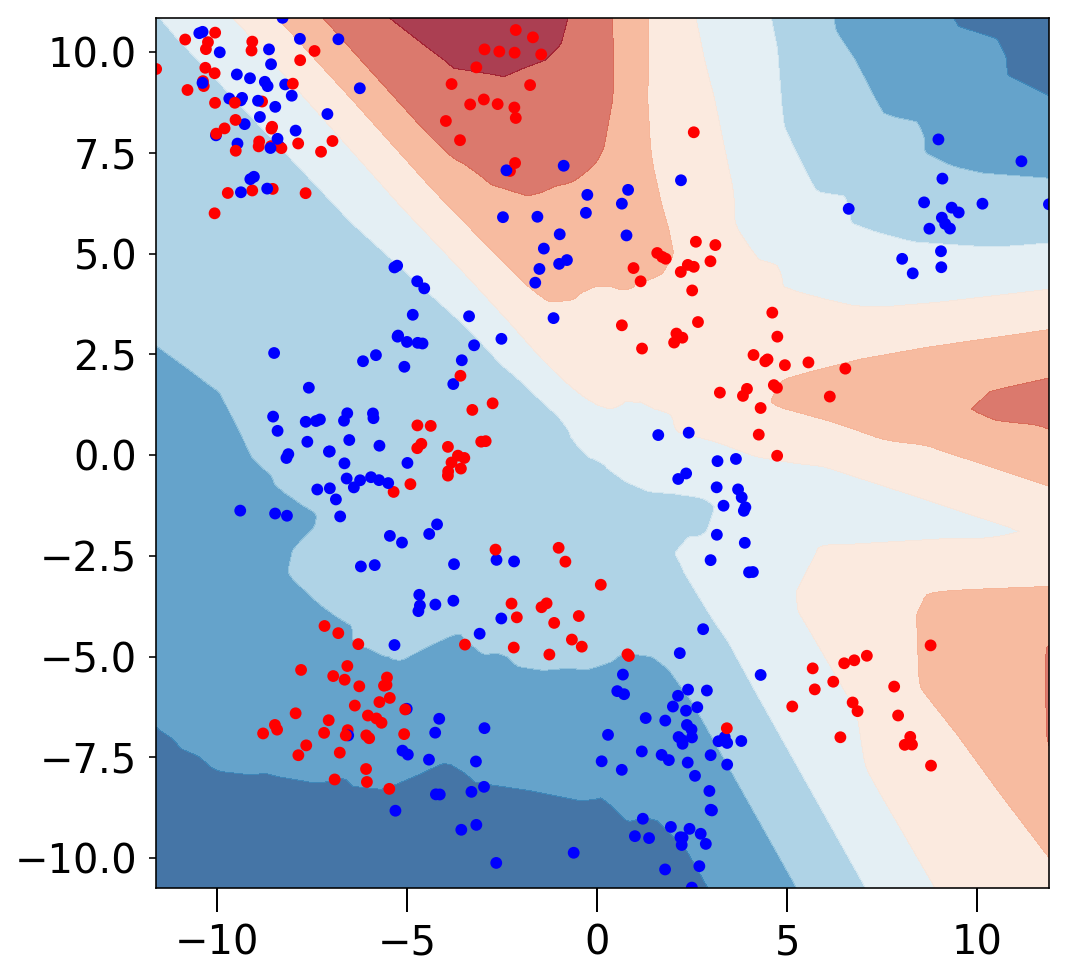

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from utils import plot_surface

labels = ["b", "r"]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))

clf = MLPClassifier(hidden_layer_sizes=(40, 40, 20), early_stopping=True,
                    validation_fraction=0.2,
                    activation='relu')

clf.fit(X, y)

plot_surface(clf, X, y)

## For any serious Neural Networking use `keras`

https://keras.io/ is a library that implements all the cool and useful layers and optimizers
that are used in today's deep learning. Importantly it uses code written in C instead of
python so it is fast (and if you have a GPU it will run on that which is even faster).

In [17]:
## world's simplest NN with keras
from keras.models import Sequential
from keras.losses import mean_squared_error

In [18]:
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.initializers import RandomUniform

# construct a model as close as possible to the one scikit-learn uses
model = Sequential()

model.add(Dense(units=1, input_dim=1,
                bias_initializer=RandomUniform(minval=-3**0.5, maxval=3**0.5)
               ))
model.add(Activation('tanh'))
# for regression the last layer in sklearn is the identity
model.add(Dense(units=1))

model.compile(loss=mean_squared_error,
              optimizer=SGD(lr=0.001))

In [19]:
np.random.seed(12345)
X = np.random.normal(scale=2, size=(1600,1))
y = X[:, 0]

history = model.fit(X, y, epochs=3200, batch_size=200, validation_split=0.2, verbose=False)

minimum loss: 0.098530555144


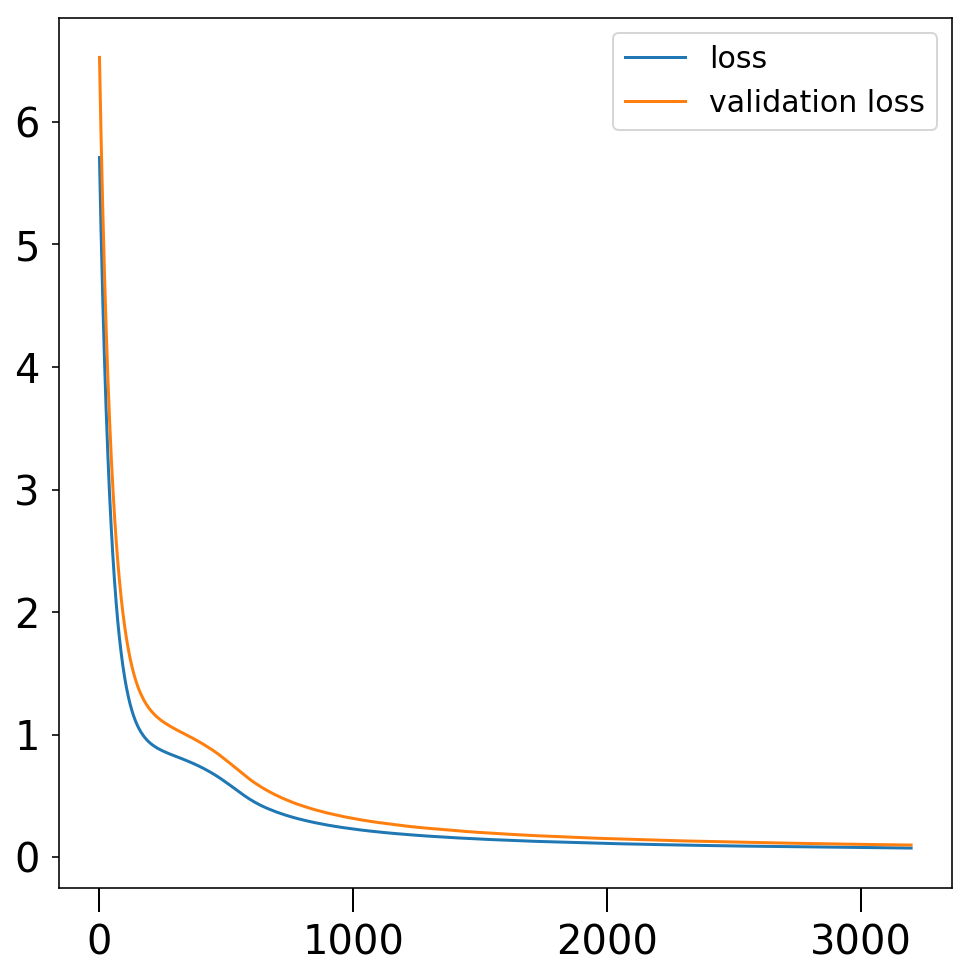

In [20]:
print('minimum loss:', np.min(history.history['val_loss']))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss');
plt.legend(loc='best');

In [21]:
model.predict([[0.], [1.5], [-1.4]])

array([[-0.00257963],
       [ 1.65783405],
       [-1.54093742]], dtype=float32)

Keras examples:
* digit recognition with a fully connected NN: https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
* digit recognition with a ConvNet: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
* ConvNet for Cifar10 https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py

## Counting parameters

Because I am too lazy to do it in my head.

In [22]:
model.count_params()

4

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 4.0
Trainable params: 4.0
Non-trainable params: 0.0
_________________________________________________________________


### Comparing a fully connected layer and a Conv layer

In [24]:
from keras.layers import Conv2D

In [25]:
fc = Sequential()
fc.add(Dense(units=4, input_dim=32*32))
fc.add(Activation('relu'))

In [26]:
fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 4100      
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
Total params: 4,100.0
Trainable params: 4,100.0
Non-trainable params: 0.0
_________________________________________________________________


In [27]:
nodes = 4
32*32*nodes + nodes

4100

In [28]:
cnn = Sequential()
cnn.add(Conv2D(4, (3, 3), input_shape=(32, 32, 1))) # 32x32 picture with one channel
# 4 -> filters: is the number of filters
# 3 -> strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the width and height. 
cnn.add(Activation('relu'))

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 4)         40        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 4)         0         
Total params: 40.0
Trainable params: 40.0
Non-trainable params: 0.0
_________________________________________________________________


In [29]:
n_filters = 4
n_filters * 3*3 + n_filters

40